In [2]:
import seaborn as sns
import folium
import geopandas as gpd
import geojson
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels
import numpy as np

In [3]:
social_indicator_df = pd.read_csv("../data/raw/social_indicator_w_postcode.csv", na_values=['-']).fillna(0)
median_rent_df = pd.read_csv("../data/raw/median_price_per_postcode.csv")

In [4]:
social_indicator_df.groupby("topic")["description"].value_counts()

topic                                description                                                                                                                                        
Arts and cultural activities         Participate in arts and cultural activities in the City of Melbourne                                                                                   11
Decision making                      Participate in activities in City of Melbourne to influence government decision making                                                                 11
Food production and consumption      Produce own food and consumed in last week                                                                                                             11
Food security                        Accessed emergency food relief services                                                                                                                11
                                     Experienced fo

In [5]:
social_indicator_health = social_indicator_df[social_indicator_df["topic"] == "Health"].groupby("postcode")["result"].mean()
social_indicator_qol = social_indicator_df[social_indicator_df["topic"] == "Quality of life"].groupby("postcode")["result"].mean()
social_indicator_learning = social_indicator_df[social_indicator_df["topic"] == "Learning"].groupby("postcode")["result"].mean()
social_indicator_safety = social_indicator_df[social_indicator_df["topic"] == "Perceptions of safety"].groupby("postcode")["result"].mean()

In [7]:
subset_meadian_rent_df = median_rent_df[median_rent_df["postcode"].isin(social_indicator_health.index)]
subset_meadian_rent_df = subset_meadian_rent_df[["postcode", "median_all_properties", "median_1_bedroom_Apartment / Unit / Flat", "median_2_bedroom_Apartment / Unit / Flat"]]
suburb_subset = median_rent_df[median_rent_df["postcode"].isin(social_indicator_health.index)][["postcode", "suburb"]].set_index("postcode")
suburb_subset = suburb_subset[~suburb_subset.index.duplicated(keep='first')]

In [8]:
social_indicator_values_df = pd.DataFrame({"health":social_indicator_health, "qol":social_indicator_qol, "learning":social_indicator_learning, "safety":social_indicator_safety})
liveability_df = pd.merge(social_indicator_values_df, subset_meadian_rent_df.set_index("postcode").groupby(level=0).mean(), left_index=True, right_index=True)
normalised_liveability_df = (liveability_df - liveability_df.min())/(liveability_df.max() - liveability_df.min())
# invert median rental price to get a positive score for affordability
normalised_liveability_df[["median_all_properties", "median_1_bedroom_Apartment / Unit / Flat", "median_2_bedroom_Apartment / Unit / Flat"]] = 1 - normalised_liveability_df[["median_all_properties", "median_1_bedroom_Apartment / Unit / Flat", "median_2_bedroom_Apartment / Unit / Flat"]]
normalised_liveability_df["score"] = normalised_liveability_df.sum(axis=1)
normalised_liveability_df = pd.merge(normalised_liveability_df, suburb_subset, left_index=True, right_index=True)

In [9]:
# calculates a weighted version of the liveability score value given a dataframe of metrics and a list of weights (defaults to even weighting)
def CalculateWeightedLiveabilityScore(dataframe, weights = [1,1,1,1,1,1,1]):
    return sum([dataframe[dataframe.columns[x]] * weights[x] for x in range(0, len(dataframe.columns) - 2)])

In [15]:
normalised_liveability_df.to_csv("../data/curated/liveability_scores.csv", index_label="postcode")

In [11]:
liveability_melted_df = normalised_liveability_df.reset_index().melt(id_vars=['suburb', 'postcode'])

In [12]:
liveability_melted_df

,suburb,postcode,variable,value
0,MELBOURNE,3000,health,0.000000
1,EAST MELBOURNE,3002,health,1.000000
2,WEST MELBOURNE,3003,health,0.393103
3,MELBOURNE,3004,health,0.624138
4,SOUTHBANK,3006,health,0.331034
...,...,...,...,...
83,FLEMINGTON,3031,score,4.813677
84,NORTH MELBOURNE,3051,score,3.320867
85,PARKVILLE,3052,score,3.157943
86,CARLTON,3053,score,4.272566


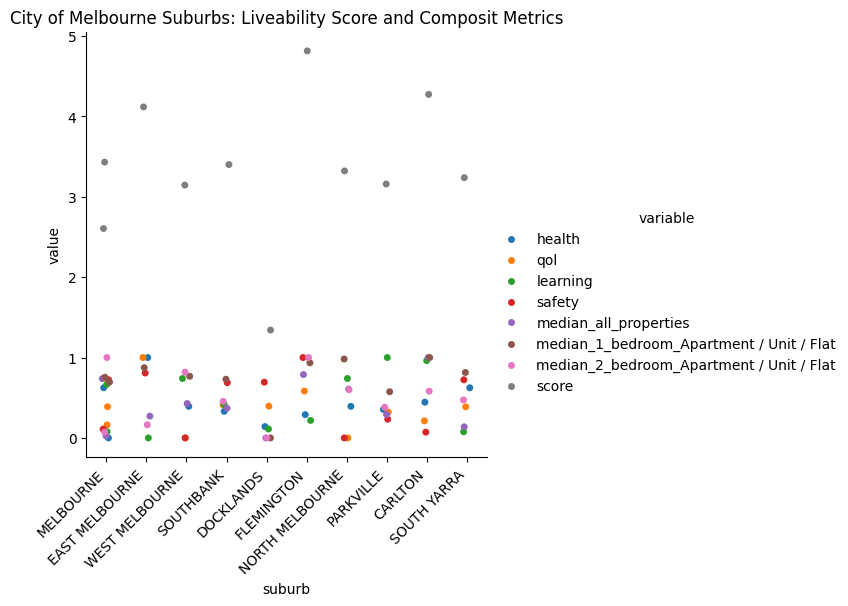

In [171]:
c_plot = sns.catplot(data = liveability_melted_df, x = "suburb", y = "value", hue = "variable")
c_plot.set_xticklabels(rotation = 45, ha='right')
c_plot.set(title="City of Melbourne Suburbs: Liveability Score and Composit Metrics")